# **Clasificación de Flores con Transfer Learning y Transformers**

En este trabajo se explora la clasificación de imágenes del dataset **Oxford Flowers 102**, que contiene 102 clases de flores con un alto grado de variabilidad en forma, color y entorno.

Inicialmente, se empleó la técnica de **transfer learning** con la arquitectura **MobileNetV2**, preentrenada en ImageNet. Tras realizar el ajuste fino del modelo (fine-tuning), se alcanzó una precisión de **94% en el conjunto de validación**. Este se encuentra en otro notebook, dentro de la misma carpeta.

Posteriormente, se utilizó un enfoque basado en **transformers para visión por computadora**, específicamente el modelo [`google/vit-base-patch16-224-in21k`](https://huggingface.co/google/vit-base-patch16-224-in21k) de Hugging Face. Tras entrenar durante **7 épocas** con ajuste fino, se logró una mejora significativa, alcanzando un **accuracy del 99% en validación**.

Este notebook documenta el proceso completo, incluyendo la preparación de datos, la configuración del modelo, el entrenamiento y la evaluación.


<h3 data-start="217" data-end="248">Sobre M&iacute;</h3>
<p data-start="249" data-end="620">Como analista de datos junior, busco aplicar mis conocimientos en an&aacute;lisis exploratorio, visualizaci&oacute;n y modelos predictivos para aportar valor en la toma de decisiones basada en datos. Me interesa crecer en entornos colaborativos donde pueda aprender de proyectos reales, desarrollar soluciones con impacto y continuar form&aacute;ndome en ciencia de datos aplicada al negocio. Tengo experiencia pr&aacute;ctica en limpieza de datos, visualizaci&oacute;n con herramientas como Matplotlib y Seaborn, y creaci&oacute;n de modelos b&aacute;sicos con scikit-learn y redes neuronales en Keras.&nbsp;</p>
<h6 style="text-align: right;" data-start="249" data-end="620">Romero Olmos, Luis Eduardo<br />Correo: <a href="mailto:luiseduardoromeroolmos@aol.com">luiseduardoromeroolmos@aol.com</a><br />Git: https://github.com/LuisEduardoRomeroOlmos<br />Kaggle: https://www.kaggle.com/luiseduardoromeroolm</h6>

## **Instalación de dependencias**

Para este proyecto utilizamos las siguientes librerías adicionales:

- `gradio`: para construir una interfaz interactiva que permita probar el modelo directamente desde el navegador.
- `transformers`: de Hugging Face, necesaria para cargar y usar modelos preentrenados como Vision Transformer (ViT).
- `evaluate`: para calcular métricas de evaluación como accuracy, precision, recall, etc.

Ejecuta el siguiente bloque para instalar las dependencias necesarias:


In [ ]:
!pip install gradio transformers
!pip install --upgrade --no-cache-dir transformers
!pip install evaluate

In [3]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: luiseduardoromeroolmos (luiseduardoromeroolmos-project) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## **Importación de librerías**

Se importan las librerías necesarias para el procesamiento de imágenes, carga del dataset, definición del modelo y entrenamiento:

- `torch`, `tensorflow_datasets` para manipulación de datos y acceso al dataset.
- `transformers` para utilizar el modelo ViT y herramientas de entrenamiento.
- `torchvision.transforms` para el preprocesamiento de imágenes.
- `PIL` y `numpy` para manipulación de imágenes y arrays.


In [4]:
import torch
import tensorflow_datasets as tfds
from transformers import AutoFeatureExtractor, ViTForImageClassification
from transformers import TrainingArguments, Trainer
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image
import numpy as np

## **Carga del dataset y modelo preentrenado**

1. Se carga el dataset **Oxford Flowers 102** desde `tensorflow_datasets`, obteniendo los splits de entrenamiento y validación.

2. Se utiliza el extractor de características y el modelo preentrenado `google/vit-base-patch16-224-in21k` de Hugging Face. Este modelo Vision Transformer se ajustará para clasificar entre las 102 clases de flores disponibles en el dataset.


In [5]:
# 1. Cargar dataset Oxford Flowers 102 con splits
tf_datasets, info = tfds.load(
    'oxford_flowers102',
    split=['train', 'validation'],
    as_supervised=True,
    with_info=True
)
train_ds, val_ds = tf_datasets


# 2. Cargar extractor y modelo preentrenado
extractor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=102
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.7OS3LS_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.7OS3LS_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.7OS3LS_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Preprocesamiento de imágenes**

Se define una secuencia de transformaciones necesaria para adaptar las imágenes al formato requerido por el modelo Vision Transformer:

- Redimensionado a 256 píxeles por lado.
- Recorte centrado a 224x224 (tamaño esperado por ViT).
- Conversión a tensores.
- Normalización utilizando la media y desviación estándar del extractor preentrenado.


In [6]:
# 3. Definir transformaciones (ViT espera 224x224 imágenes normalizadas)
transform = Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=extractor.image_mean, std=extractor.image_std),
])

## **Conversión del dataset y preparación para entrenamiento**

4. Se define una función `preprocess_tfds` para transformar cada ejemplo del dataset original (`tf.data.Dataset`) en un diccionario con los campos requeridos por Hugging Face Trainer: `pixel_values` e `labels`.

5. Se convierte el dataset de TensorFlow a NumPy con `tfds.as_numpy`, y luego se aplica la transformación a cada imagen para obtener listas de ejemplos preprocesados.

6. Se construyen datasets personalizados de PyTorch (`torch.utils.data.Dataset`) para entrenamiento y validación, encapsulando las listas preprocesadas y asegurando compatibilidad con el entrenamiento en Hugging Face.

Además, se configura la herramienta **Weights & Biases (W&B)** para el seguimiento de métricas y experimentos, iniciando sesión e inicializando el proyecto `vit-flowers`.


In [7]:
# 4. Función para convertir ejemplo tfds a diccionario esperado por Trainer
def preprocess_tfds(example, label):
    img = Image.fromarray(example)
    pixel_values = transform(img)
    return {"pixel_values": pixel_values, "labels": label}


# 5. Procesar datasets

train_ds_np = tfds.as_numpy(train_ds)
val_ds_np = tfds.as_numpy(val_ds)

train_dataset = [preprocess_tfds(img, label) for img, label in train_ds_np]
val_dataset = [preprocess_tfds(img, label) for img, label in val_ds_np]


# 6. Crear Dataset PyTorch custom (con __getitem__ y __len__)
class FlowersDataset(torch.utils.data.Dataset):
    def __init__(self, data_list):
        self.data = data_list
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

train_dataset = FlowersDataset(train_dataset)
val_dataset = FlowersDataset(val_dataset)

In [8]:
!wandb login 5bac884898112eddfe13cafcacdbb6fcc379c709

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [9]:
import wandb
wandb.init(project="vit-flowers", name="entrenamiento-manual")

wandb: Currently logged in as: luiseduardoromeroolmos (luiseduardoromeroolmos-project) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## **Configuración de argumentos de entrenamiento**

Se definen los parámetros utilizados por `TrainingArguments` para el entrenamiento del modelo:

- `output_dir`: directorio donde se guardarán los checkpoints.
- `per_device_train_batch_size` y `per_device_eval_batch_size`: tamaño de batch para entrenamiento y evaluación.
- `num_train_epochs`: número total de épocas de entrenamiento (7 en este caso).
- `learning_rate`: tasa de aprendizaje inicial.
- `weight_decay`: regularización L2 para evitar sobreajuste.
- `logging_dir` y `logging_steps`: configuración del registro de métricas.
- `run_name`: nombre identificador del experimento (útil para W&B).


In [10]:
# 7. Definir argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./vit-flowers-finetuned",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=7,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    run_name="vit-flowers-exp1"
)

## **Definición de métrica de evaluación y creación del Trainer**

8. Se define una función `compute_metrics` para calcular la métrica de precisión (*accuracy*) utilizando la librería `evaluate` de Hugging Face. Esta función se usará para evaluar el rendimiento del modelo durante el entrenamiento.

9. Se crea una instancia de `Trainer`, el cual automatiza el proceso de entrenamiento y validación. Se le proporciona el modelo, los datasets, los argumentos de entrenamiento y la función de evaluación.


In [11]:
# 8. Función de evaluación (opcional, aquí usamos accuracy)
import evaluate
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

# 9. Crear Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

## **Entrenamiento y evaluación del modelo**

10. Se entrena el modelo Vision Transformer durante 7 épocas utilizando el objeto `Trainer`. El entrenamiento se realiza de forma automática con validación periódica y seguimiento del `loss`.

Al finalizar el entrenamiento, se evalúa el modelo sobre el conjunto de validación. Los resultados obtenidos fueron:

- **Pérdida (loss) en entrenamiento:** 2.92
- **Pérdida (loss) en validación:** 2.47
- **Precisión (accuracy) en validación:** 98.5%

Estos resultados reflejan una mejora significativa respecto al modelo anterior basado en MobileNetV2 (94%), lo que confirma el poder de los modelos tipo Transformer para tareas de clasificación de imágenes.


In [12]:
# 10. Entrenar modelo
trainer.train()

Step,Training Loss
10,4.610000
20,4.586000
30,4.544900
40,4.455000
50,4.440400
60,4.390000
70,4.379700
80,4.321600
90,4.248700
100,4.219900


TrainOutput(global_step=896, training_loss=2.9250815383025577, metrics={'train_runtime': 14788.5093, 'train_samples_per_second': 0.483, 'train_steps_per_second': 0.061, 'total_flos': 5.537887046892749e+17, 'train_loss': 2.9250815383025577, 'epoch': 7.0})

In [13]:
results = trainer.evaluate()
print(results)

{'eval_loss': 2.475130081176758, 'eval_accuracy': 0.9852941176470589, 'eval_runtime': 673.357, 'eval_samples_per_second': 1.515, 'eval_steps_per_second': 0.19, 'epoch': 7.0}


## **Evaluación detallada del modelo: Reporte de clasificación**

Se obtuvieron las predicciones sobre el conjunto de validación utilizando el método `predict` de `Trainer`. A partir de las etiquetas verdaderas (`y_true`) y las predicciones del modelo (`y_pred`), se generó un reporte de clasificación con `sklearn.metrics.classification_report`.

Este reporte incluye precisión (*precision*), recuperación (*recall*) y puntuación F1 (*f1-score*) para cada una de las 102 clases del dataset Oxford Flowers 102.

### **Resultados destacados:**

- El modelo alcanza un **accuracy global del 99%** sobre el conjunto de validación.
- La mayoría de las clases presentan métricas perfectas (1.00), lo cual indica una excelente capacidad del modelo para distinguir entre distintas especies de flores.
- Algunas clases, como *"sweet pea"* o *"sword lily"*, presentan ligeras caídas en recall, lo que puede deberse a similitudes visuales entre flores o a variaciones en las imágenes.

Estos resultados demuestran el alto poder de generalización del modelo **Vision Transformer (ViT)** cuando se aplica fine-tuning sobre un dataset específico de clasificación de imágenes.


In [14]:
from sklearn.metrics import classification_report, confusion_matrix


# Obtener predicciones con Trainer
predictions = trainer.predict(val_dataset)

# Extraer etiquetas verdaderas y predichas
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

In [15]:
label_names = info.features['label'].names
print(label_names[:5])  # ejemplo

['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold']


In [16]:
report = classification_report(y_true, y_pred, target_names=label_names)
print(report)

                           precision    recall  f1-score   support

            pink primrose       1.00      1.00      1.00        10
hard-leaved pocket orchid       1.00      1.00      1.00        10
         canterbury bells       1.00      1.00      1.00        10
                sweet pea       0.77      1.00      0.87        10
         english marigold       1.00      1.00      1.00        10
               tiger lily       1.00      1.00      1.00        10
              moon orchid       1.00      1.00      1.00        10
         bird of paradise       0.91      1.00      0.95        10
                monkshood       0.91      1.00      0.95        10
            globe thistle       1.00      1.00      1.00        10
               snapdragon       1.00      1.00      1.00        10
              colt's foot       1.00      1.00      1.00        10
              king protea       1.00      1.00      1.00        10
            spear thistle       1.00      1.00      1.00     

## **Guardado del modelo y extractor**

Finalmente, se guardan el modelo ajustado (`fine-tuned`) y el extractor de características en el directorio `./vit-flowers-finetuned`.

Esto permite reutilizar el modelo entrenado y el preprocesador para futuras inferencias o despliegues sin necesidad de reentrenar.


In [17]:
# 11. Guardar modelo ajustado
trainer.save_model("./vit-flowers-finetuned")

In [18]:
#12. Guardar el extractor
extractor.save_pretrained("./vit-flowers-finetuned")

['./vit-flowers-finetuned/preprocessor_config.json']

## **Inferencia con modelo guardado y visualización de imagen**

- Se cargan el modelo y el extractor previamente guardados.
- Se recuperan los nombres de las clases desde el dataset `oxford_flowers102` para facilitar la interpretación de las predicciones.
- Se define la función `predecir_flor`, que recibe la ruta de una imagen, realiza el preprocesamiento necesario y devuelve la clase predicha con su nombre correspondiente.
- Finalmente, se muestra una imagen de ejemplo (`rosa.jpg`) y se imprime la predicción obtenida.

Este procedimiento permite realizar inferencias sobre imágenes nuevas de forma sencilla y directa.


In [19]:
from transformers import AutoModelForImageClassification, AutoImageProcessor
from PIL import Image
import torch
import tensorflow_datasets as tfds

In [20]:
# Cargar nombres de clases desde TFDS
# Cargar nombres de clase
_, info = tfds.load("oxford_flowers102", with_info=True)
label_names = info.features["label"].names

# Cargar modelo y extractor
model = AutoModelForImageClassification.from_pretrained("./vit-flowers-finetuned")
extractor = AutoFeatureExtractor.from_pretrained("./vit-flowers-finetuned")
model.eval()

def predecir_flor(path_imagen):
    image = Image.open(path_imagen).convert("RGB")
    inputs = extractor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        predicted_class = outputs.logits.argmax(-1).item()

    return f"Clase predicha: {predicted_class} → {label_names[predicted_class]}"

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


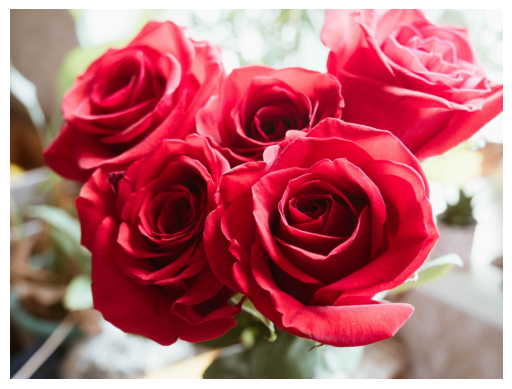

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/content/rosa.jpg")
plt.imshow(img)
plt.axis('off')  # Quitar ejes
plt.show()

In [21]:
resultado = predecir_flor("/content/rosa.jpg")
print(resultado)

Clase predicha: 73 → rose
